# Install Packages & Data

In [1]:
!pip install statsmodels --quiet

In [2]:
import numpy as np
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from sklearn.preprocessing import StandardScaler
import os
import statsmodels as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from numpy.linalg import inv, eig
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
import threading
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score

Import Data

In [3]:
path_data = '/content/data.csv' #edit path as necessary

# Check if files exist before loading
if os.path.exists(path_data):
    data = pd.read_csv(path_data)
    print("Data loaded successfully.")
else:
    print("Error: One or both files not found. Check the file paths.")

y = data.loc[:,'ViolentCrimesPerPop']
X = data.loc[:, data.columns != 'ViolentCrimesPerPop']

Data loaded successfully.


Import Significant Features Data from notebook 1. (So we do not have to run best subsets and/or SFS again).

In [4]:
file_path = "/content/SignificantFeaturesData.json" #adjust as needed

if os.path.exists(file_path):
    with open(file_path, "r") as f:
        significantfeatures_dict = json.load(f)
    print("JSON file loaded successfully.")
else:
    # Default data if file isn't found
    significantfeatures_dict = {"default_key": ["default_value1", "default_value2"]}
    print("File not found. Loaded default data.")


JSON file loaded successfully.


# Split & Store Data

We want to split the data into 60% training, 20% validation, and 20% test set. We will then use the data as follows:

Training - fit the model

Validation - hyperparameter tuning (if needed, e.g. LASSO)

Test set - evaluate MSE using model we fit with the training data

In [5]:
data_splits = {}

M = 10 #number of iterations
for i in range(M):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(100))
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=np.random.randint(100))

    data_splits[f"data{i+1}"] = {
        "X_train": X_train,
        "X_val": X_val,
        "X_test": X_test,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test
    }

alldata = list(data_splits.keys())

It to allow a fair comparison of MSE between methods that have a validation set and those that dont as the methods that have a validation set and avoid some methods from ussing more of the data we will include the validation in the training data when required.

Store all MSE below.

In [6]:
methods_mse = {'Least Squares':[],
               'Best Subsets biased':[],
               'SFS unbiased':[],
               'SFS biased':[],
               'LASSO':[],
               'Ridge':[],
               'Elastic Net':[]
}

# Train, Validate, Test

Now we calculate MSE for each method on datasets 1,2,...,10.

## Least Squares

In [7]:
ls_mse = {data_i:0 for data_i in alldata}

for data_i in alldata:

  ##Prep - Training & Validation Combined##
  X_train = data_splits[data_i]['X_train']
  X_validate = data_splits[data_i]['X_val']
  X_ = pd.concat([X_train,X_validate]) #to avoid wasting data
  X_ = sm.add_constant(X_) #add constant

  y_train = data_splits[data_i]['y_train']
  y_validate = data_splits[data_i]['y_val']
  y_ = pd.concat([y_train,y_validate]) #to avoid wasting data

  ##Prep - Test##
  X_test = data_splits[data_i]['X_test']
  X_test = sm.add_constant(X_test) #add constant

  y_test = data_splits[data_i]['y_test']

  lsmodel = OLS(y_,X_).fit() #fit using training
  y_pred = lsmodel.predict(X_test) #predict using test
  mse = mean_squared_error(y_test, y_pred) #evaluate using test
  ls_mse[data_i] = mse

#Add to dictionary
methods_mse['Least Squares'] = ls_mse

Plot MSE for each sample (1,...,10).

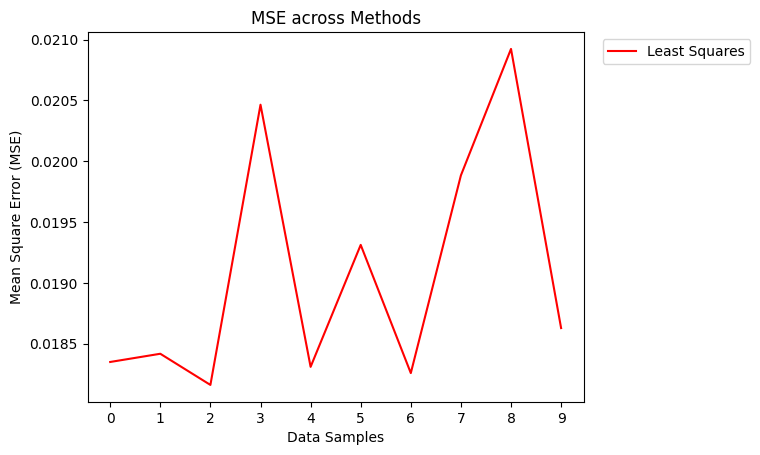

In [8]:
plt.plot(methods_mse['Least Squares'].values(), label = 'Least Squares', color = 'red')
plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Data Samples')
plt.title('MSE across Methods')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1));
plt.xticks(range(0, 10, 1));

## Best Subsets

### Best Subsets - Unbiased Method (not computationally feasible)

We have already run the best subsets in notebook 1.  However, recall we performed extensive filtering before running this in order to get the features down from 100 variables to a manageable number in order to perform the computations on cpu.  When we applied this filtering we used the entire data set which biases the results in the test set.  Therefore, let us perform another filtering using only the training set (in this method training set = training set + validation set - as we are not hyperparameter tuning so we do not need a validation set).  We will perform the last filtering method from notebook 1 - drop variables such that:

$$\text{Cov}(X_i, y) < \tau$$

However, since we are iterating for multiple test sets instead to make this computationally feasible let us just pull the top M features with the highest covariance with y.  



In [9]:
M = 2

Now we will store the top M correlated features based on our filtering method (using training = (training + validation) b/c we have no hyperparameters to tune, i.e., no use for valdiation) in the following dictionary.

In [10]:
bestsubsetsfeatures_dict = {data_i:[] for data_i in alldata}

Issue.  This code is not compuationally feasible on cpu (dont believe me? change seconds to a higher number an wait :)

In [13]:
seconds = 5

In [14]:
def my_code():

  BestSubests_mse = {data_i:0 for data_i in alldata}

  for data_i in alldata:

    X_train = data_splits[data_i]['X_train']
    X_validate = data_splits[data_i]['X_val']
    X_ = pd.concat([X_train,X_validate]) #to avoid wasting data

    y_train = data_splits[data_i]['y_train']
    y_validate = data_splits[data_i]['y_val']
    y_ = pd.concat([y_train,y_validate]) #to avoid wasting data

    #Filter using training data
    corr_df = X_.corrwith(y_).to_frame(name='Corr(x_i, y)');
    corr_df['Absolute Correlation'] = corr_df.apply(lambda x: abs(x));
    corr_df = corr_df.sort_values(by = 'Absolute Correlation', ascending = False)

    #Top M features
    colnames = X.columns
    features = list(corr_df['Absolute Correlation'].head(M).index)

    # Define a linear regression model
    linear_reg = LinearRegression()

    #Obtain exhaustive mse values
    efs = EFS(
          linear_reg,
          min_features=1,
          max_features=8,
          scoring="neg_mean_squared_error", #use negative MSE b/c EFS maximizes the score
          cv=0)

    #Fit Best Subsets using the training data
    efs.fit(X_, y_)

    bestsubsets_features = list(efs.best_idx_)  # Get indices of selected features
    bestsubsets_feature_names = [colnames[i] for i in bestsubsets_features]  # Convert indices to names

    ##Prep - Training & Validation Combined##
    X_ = X_[bestsubsets_feature_names] #Drop all unneccessary features
    X_ = sm.add_constant(X_) #add constant

    y_train = data_splits[data_i]['y_train']
    y_validate = data_splits[data_i]['y_val']
    y_ = pd.concat([y_train,y_validate]) #to avoid wasting data

    ##Prep - Test##
    X_test = data_splits[data_i]['X_test']
    X_test = X_test[bestsubsets_feature_names] #Drop all unneccessary features
    X_test = sm.add_constant(X_test) #add constant

    y_test = data_splits[data_i]['y_test']

    BestSubsets_lsmodel = OLS(y_,X_).fit() #fit on training data (train + val)
    y_pred = BestSubsets_lsmodel.predict(X_test) #predict on X_test
    mse = mean_squared_error(y_test, y_pred) #Evaluate on y_test
    BestSubests_mse[data_i] = mse

  methods_mse['Best Subsets'] = BestSubests_mse


thread = threading.Thread(target=my_code)
thread.start()

thread.join(timeout=seconds)

if thread.is_alive():
    print("Code took too long to run; not compuationally feasible.")

Code took too long to run; not compuationally feasible.


### Best Subsets - biased Method (computationally feasible)

In [15]:
bestsubsetsfeatures_ = significantfeatures_dict['Best Subsets']
print(bestsubsetsfeatures_)

['PctVacantBoarded', 'PctWOFullPlumb', 'LemasPctOfficDrugUn', 'NumStreet', 'MedRentPctHousInc', 'PctHousOccup', 'PopDens', 'blackPerCap']


In [16]:
BestSubests_mse = {data_i:0 for data_i in alldata}

for data_i in alldata:

  ##Prep - Training & Validation Combined##
  X_train = data_splits[data_i]['X_train']
  X_validate = data_splits[data_i]['X_val']
  X_ = pd.concat([X_train,X_validate]) #to avoid wasting data
  X_ = X_[bestsubsetsfeatures_] #Drop all unneccessary features & use features from best subsets
  X_ = sm.add_constant(X_) #add constant

  y_train = data_splits[data_i]['y_train']
  y_validate = data_splits[data_i]['y_val']
  y_ = pd.concat([y_train,y_validate]) #to avoid wasting data

  ##Prep - Test##
  X_test = data_splits[data_i]['X_test']
  X_test = X_test[bestsubsetsfeatures_] #Drop all unneccessary features
  X_test = sm.add_constant(X_test) #add constant

  y_test = data_splits[data_i]['y_test']

  BestSubsets_lsmodel = OLS(y_,X_).fit() #fit on training data (train + val)
  y_pred = BestSubsets_lsmodel.predict(X_test) #predict on X_test
  mse = mean_squared_error(y_test, y_pred) #Evaluate on y_test
  BestSubests_mse[data_i] = mse

methods_mse['Best Subsets biased'] = BestSubests_mse

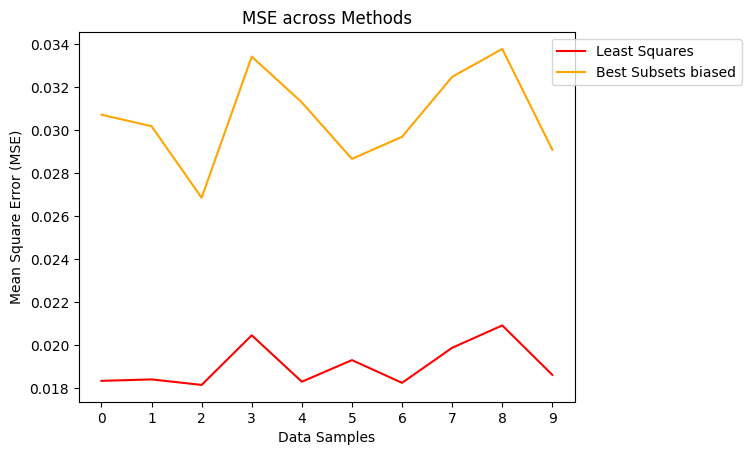

In [17]:
plt.plot(methods_mse['Least Squares'].values(), label = 'Least Squares', color = 'red')
plt.plot(methods_mse['Best Subsets biased'].values(), label = 'Best Subsets biased', color = 'orange')
plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Data Samples')
plt.title('MSE across Methods')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1));
plt.xticks(range(0, 10, 1));

It seems like Best Subsets should have performed better due to the filtering done while peaking into the test set.  The naive filtering was likely the issue.

## Sequential Feature Selection (SFS)

### SFS - Unbiased Method

Sequential Feature Selection (SFS) is a popular technique for feature selection in machine learning, where the goal is to identify a subset of relevant features from a larger set of features that contribute the most to the predictive performance of a model. SFS can be implemented in two main strategies: forward selection and backward elimination. However, to avoid overfitting and ensure that the selected feature subset generalizes well to unseen data, it is crucial to use a validation set during the SFS process.

The Role of a Validation Set
In machine learning, the dataset is typically divided into three subsets: the training set, the validation set, and the test set.

*   Training Set: Used to train the model and estimate the model parameters.
*   Validation Set: Used to evaluate the model performance during training, helping in the selection of model parameters and in feature selection. It is not used for training but helps monitor the model's ability to generalize.
*   Test Set: Used to assess the final model's performance after training and feature selection.

Risk of Overfitting:

The main risk of combining the training and validation sets is overfitting. Since you're using the same data for both training the model and evaluating its performance during the feature selection process, you could select features that overfit to this combined dataset. This would mean that the selected features may not generalize well to unseen data (e.g., the test set).

Therefore, we cannot naively combine the training and validation in this case.  Instead we will combine these two but use cross validation which will split the 'training' set (which is our combined training and validation) into k-fold training and validation.  We will use k = 5.  

In [18]:
#defining aic evaluation functions compatible with mlxtend.feature_selection.SequentialFeatureSelector
def calculate_aic(estimator, X, y):
    """
    Custom AIC scorer for SequentialFeatureSelector.
    Args:
        estimator: A fitted sklearn-compatible estimator.
        X: Features (numpy array).
        y: Target variable (numpy array).
    Returns:
        Negative AIC value for compatibility with SFS (higher is better).
    """
    n, k = X.shape  # n: number of samples, k: number of predictors
    y_pred = estimator.predict(X)
    residual_sum_of_squares = np.sum((y - y_pred) ** 2)
    aic = n * np.log(residual_sum_of_squares / n) + 2 * k
    return -aic  # SFS maximizes the score

def aic_scorer_wrapper(estimator, X, y):
    estimator.fit(X, y)
    return calculate_aic(estimator, X, y)

In [19]:
SFS_mse = {data_i:0 for data_i in alldata}

for data_i in alldata:

  ##Prep - Training & Validation Combined##
  X_train = data_splits[data_i]['X_train']
  X_validate = data_splits[data_i]['X_val']
  X_ = pd.concat([X_train,X_validate]) #to avoid wasting data
  X_ = X_[bestsubsetsfeatures_] #Drop all unneccessary features & use features from best subsets

  y_train = data_splits[data_i]['y_train']
  y_validate = data_splits[data_i]['y_val']
  y_ = pd.concat([y_train,y_validate]) #to avoid wasting data

  ##Prep - Test##
  X_test = data_splits[data_i]['X_test']
  X_test = X_test[bestsubsetsfeatures_] #Drop all unneccessary features

  y_test = data_splits[data_i]['y_test']

  # Step 2: Standardize the data (center and scale)
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_)  # Fit and transform on the training data
  X_test_scaled = scaler.transform(X_test)        # Only transform the test data

  # Step 3: Initialize the model
  model = LinearRegression()

  # Step 4: Initialize Sequential Feature Selector with cross-validation
  sfs = SequentialFeatureSelector(estimator=model, n_features_to_select='auto', direction='backward', cv=5)

  # Step 5: Perform feature selection on the standardized data
  sfs.fit(X_train_scaled, y_)

  # Step 6: Get the selected features
  selected_features = sfs.get_support(indices=True)
  X_train_selected = X_train_scaled[:, selected_features]

  # Train the model on the selected features
  model.fit(X_train_selected, y_)

  # Step 7: Evaluate on the test set (final evaluation)
  X_test_selected = X_test_scaled[:, selected_features]
  y_test_pred = model.predict(X_test_selected)

  mse = mean_squared_error(y_test, y_test_pred)

  SFS_mse[data_i] = mse

methods_mse['SFS unbiased'] = SFS_mse

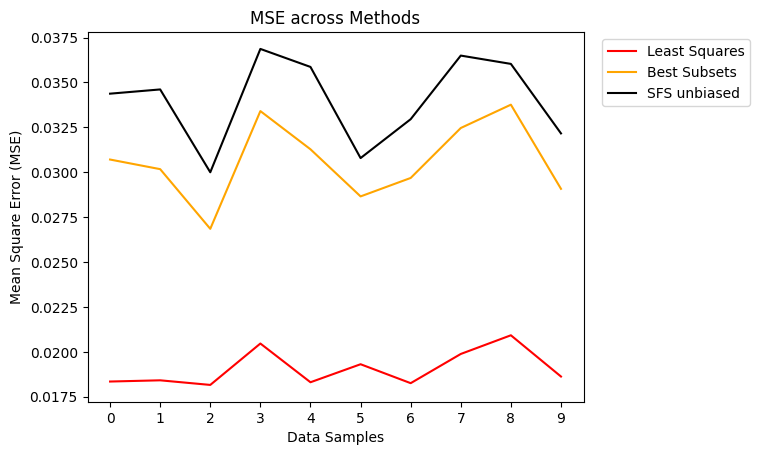

In [20]:
plt.plot(methods_mse['Least Squares'].values(), label = 'Least Squares', color = 'red')
plt.plot(methods_mse['Best Subsets biased'].values(), label = 'Best Subsets', color = 'orange')
plt.plot(methods_mse['SFS unbiased'].values(), label = 'SFS unbiased', color = 'black')

plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Data Samples')
plt.title('MSE across Methods')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1));
plt.xticks(range(0, 10, 1));

### SFS - Biased Method

Now let us use the results from SFS in notebook 1, i.e., use the significant features where we ran SFS on the entire dataset. In doing so we peaked into the test set.  This will lead to bias results and SFS will perform far better then it should compared to 'SFS unbiased'.

In [21]:
significantfeaturesSFS = significantfeatures_dict['SFS']
print(significantfeaturesSFS) #features from notebook 1

['racepctblack', 'racePctWhite', 'racePctHisp', 'agePct12t29', 'agePct16t24', 'numbUrban', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWRetire', 'medFamInc', 'whitePerCap', 'indianPerCap', 'AsianPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctBSorMore', 'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'MalePctDivorce', 'MalePctNevMarr', 'TotalPctDiv', 'PctKids2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'RentLowQ', 'RentHighQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctUsePubTrans', 'LemasPctOfficDrugUn', 'OtherPerCap']


In [23]:
SFS2_mse = {data_i:0 for data_i in alldata}

for data_i in alldata:

  ##Prep - Training & Validation Combined##
  X_train = data_splits[data_i]['X_train']
  X_validate = data_splits[data_i]['X_val']
  X_ = pd.concat([X_train,X_validate]) #to avoid wasting data
  X_ = X_[significantfeaturesSFS] #Drop all unneccessary features & use features from SFS
  X_ = sm.add_constant(X_) #add constant

  y_train = data_splits[data_i]['y_train']
  y_validate = data_splits[data_i]['y_val']
  y_ = pd.concat([y_train,y_validate]) #to avoid wasting data

  ##Prep - Test##
  X_test = data_splits[data_i]['X_test']
  X_test = X_test[significantfeaturesSFS] #Drop all unneccessary features
  X_test = sm.add_constant(X_test) #add constant

  y_test = data_splits[data_i]['y_test']


  SFS_lsmodel = OLS(y_,X_).fit() #fit using training
  y_pred = SFS_lsmodel.predict(X_test) #predict using test
  mse = mean_squared_error(y_test, y_pred) #evaluate MSE on y_test and y_pred
  SFS2_mse[data_i] = mse

methods_mse['SFS biased'] = SFS2_mse

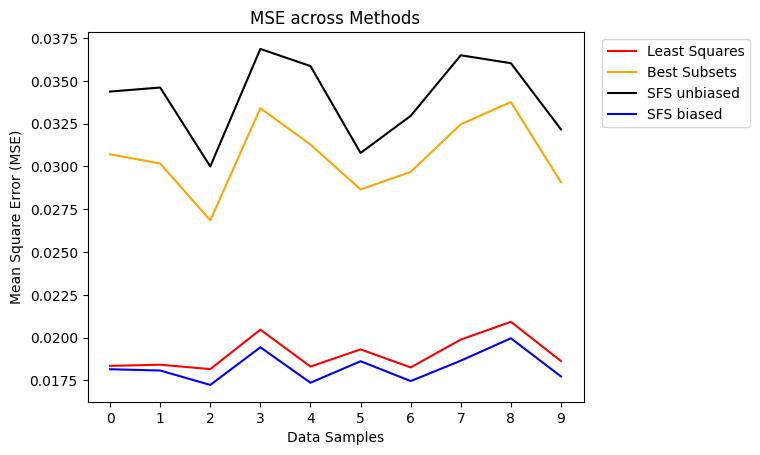

In [24]:
plt.plot(methods_mse['Least Squares'].values(), label = 'Least Squares', color = 'red')
plt.plot(methods_mse['Best Subsets biased'].values(), label = 'Best Subsets', color = 'orange')
plt.plot(methods_mse['SFS unbiased'].values(), label = 'SFS unbiased', color = 'black')
plt.plot(methods_mse['SFS biased'].values(), label = 'SFS biased', color = 'blue')

plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Data Samples')
plt.title('MSE across Methods')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1));
plt.xticks(range(0, 10, 1));

As we expected, SFS biased performs very well on the test set.  As it should as we ran this using the test set data!  Therefore this method has overfit the data and should we run this on new unseen data it would not be suprising if it performed far worse.

## LASSO

In [25]:
lasso_mse2 = {data_i: {} for data_i in alldata}

for data_i in alldata:
    X_train, y_train = data_splits[data_i]['X_train'], data_splits[data_i]['y_train']
    X_val, y_val = data_splits[data_i]['X_val'], data_splits[data_i]['y_val']
    X_test, y_test = data_splits[data_i]['X_test'], data_splits[data_i]['y_test']

    # Center and scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    lasso_model = Lasso(max_iter=1000000)

    # Hyperparameter tuning by manually testing alpha values on the validation set
    alpha_values = np.logspace(-4, 4, 10)
    best_alpha = None
    best_mse = float('inf')  # Initialize with a large value to track minimum MSE

    for alpha in alpha_values:
        lasso_model.set_params(alpha=alpha)
        lasso_model.fit(X_train_scaled, y_train)
        y_val_pred = lasso_model.predict(X_val_scaled)
        mse = mean_squared_error(y_val, y_val_pred)

        if mse < best_mse:
            best_mse = mse
            best_alpha = alpha

    lasso_best = Lasso(alpha=best_alpha, max_iter = 1000000)
    lasso_best.fit(X_train_scaled, y_train)
    y_test_pred = lasso_best.predict(X_test_scaled)

    mse_test = mean_squared_error(y_test, y_test_pred)
    lasso_mse2[data_i] = mse_test

#Add data
methods_mse['LASSO'] = {'Parameter': best_alpha, 'MSE':lasso_mse2}

## Ridge

In [26]:
ridge_mse = {data_i: {} for data_i in alldata}

for data_i in alldata:
    X_train, y_train = data_splits[data_i]['X_train'], data_splits[data_i]['y_train']
    X_val, y_val = data_splits[data_i]['X_val'], data_splits[data_i]['y_val']
    X_test, y_test = data_splits[data_i]['X_test'], data_splits[data_i]['y_test']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    ridge_model = Ridge(max_iter=10000)

    alpha_values = np.logspace(-4, 4, 10)
    best_alpha = None
    best_mse = float('inf')

    for alpha in alpha_values:
        ridge_model.set_params(alpha=alpha)
        ridge_model.fit(X_train_scaled, y_train)
        y_val_pred = ridge_model.predict(X_val_scaled)
        mse = mean_squared_error(y_val, y_val_pred)

        if mse < best_mse:
            best_mse = mse
            best_alpha = alpha

    ridge_best = Ridge(alpha=best_alpha)
    ridge_best.fit(X_train_scaled, y_train)

    y_test_pred = ridge_best.predict(X_test_scaled)

    mse_test = mean_squared_error(y_test, y_test_pred)
    ridge_mse[data_i] = mse_test

#Add data
methods_mse['Ridge'] = {'Parameter': best_alpha, 'MSE':ridge_mse}

## Elastic Net

In [27]:
import warnings
import time

start = time.time()

warnings.filterwarnings("ignore")

elasticnet_mse = {data_i: {} for data_i in alldata}

for data_i in alldata:
    X_train, y_train = data_splits[data_i]['X_train'], data_splits[data_i]['y_train']
    X_val, y_val = data_splits[data_i]['X_val'], data_splits[data_i]['y_val']
    X_test, y_test = data_splits[data_i]['X_test'], data_splits[data_i]['y_test']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    elasticnet_model = ElasticNet(max_iter=10000)

    alpha_values = np.logspace(-4, 4, 10)
    l1_ratio_values = np.linspace(0, 1, 10)  # L1 ratio ranges from 0 (Ridge) to 1 (Lasso)
    best_alpha = None
    best_l1_ratio = None
    best_mse = float('inf')

    # We loop through all combinations of penalty (alpha) and ratio between l1 and l2 to find best combination in set  {alpha_values, l1_ratio_values}
    for alpha in alpha_values:
        for l1_ratio in l1_ratio_values:
            elasticnet_model.set_params(alpha=alpha, l1_ratio=l1_ratio)
            elasticnet_model.fit(X_train_scaled, y_train)
            y_val_pred = elasticnet_model.predict(X_val_scaled)
            mse = mean_squared_error(y_val, y_val_pred)

            if mse < best_mse:
                best_mse = mse
                best_alpha = alpha
                best_l1_ratio = l1_ratio

    elasticnet_best = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=10000)
    elasticnet_best.fit(X_train_scaled, y_train)

    y_test_pred = elasticnet_best.predict(X_test_scaled)

    mse_test = mean_squared_error(y_test, y_test_pred)
    elasticnet_mse[data_i] = mse_test

end = time.time()
passed = end - start
print(f"Execution time: {passed:.4f} seconds")

# Add data
methods_mse['Elastic Net'] = {'Parameters (alpha, l1 ratio)': (best_alpha, best_l1_ratio), 'MSE': elasticnet_mse}

Execution time: 285.0583 seconds


# Visualization of Methods (MSE)

## MSE for each Data Sample

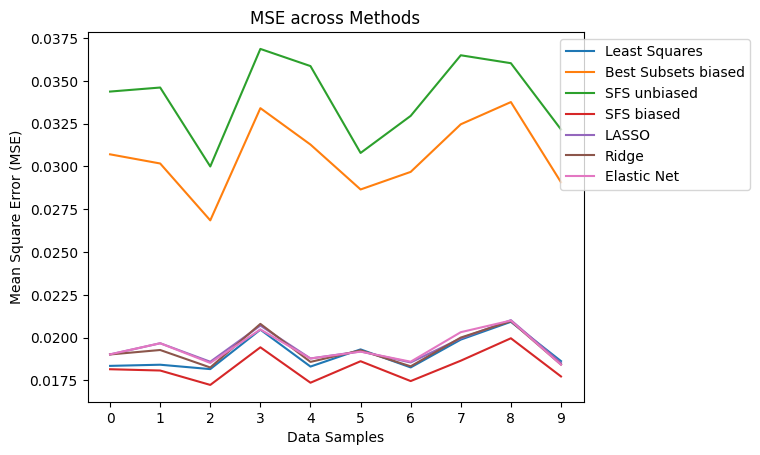

In [28]:
for key, val in methods_mse.items():
  if len(list(methods_mse[key])) == 10:
    plt.plot(methods_mse[key].values(), label = key)
  else:
    plt.plot(methods_mse[key]['MSE'].values(), label = key)

plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Data Samples')
plt.title('MSE across Methods')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1));
plt.xticks(range(0, 10, 1));

Suprisingly, Best Subsets performed very poorly compared to the other methods even though we peeked into the testing set when filtering the variables. This is likely due to the fact that in order to perform best subsets within a reasonable computational time we had to perform extensive naive feature filtering. Clearly, this led to poor predictive performance in the model.

It appears that in this regression analysis, LS performed the best according the the MSE if we exclude biased SFS (as it overfit the testing data).

**!!!Enlarged for better visuals!!!**

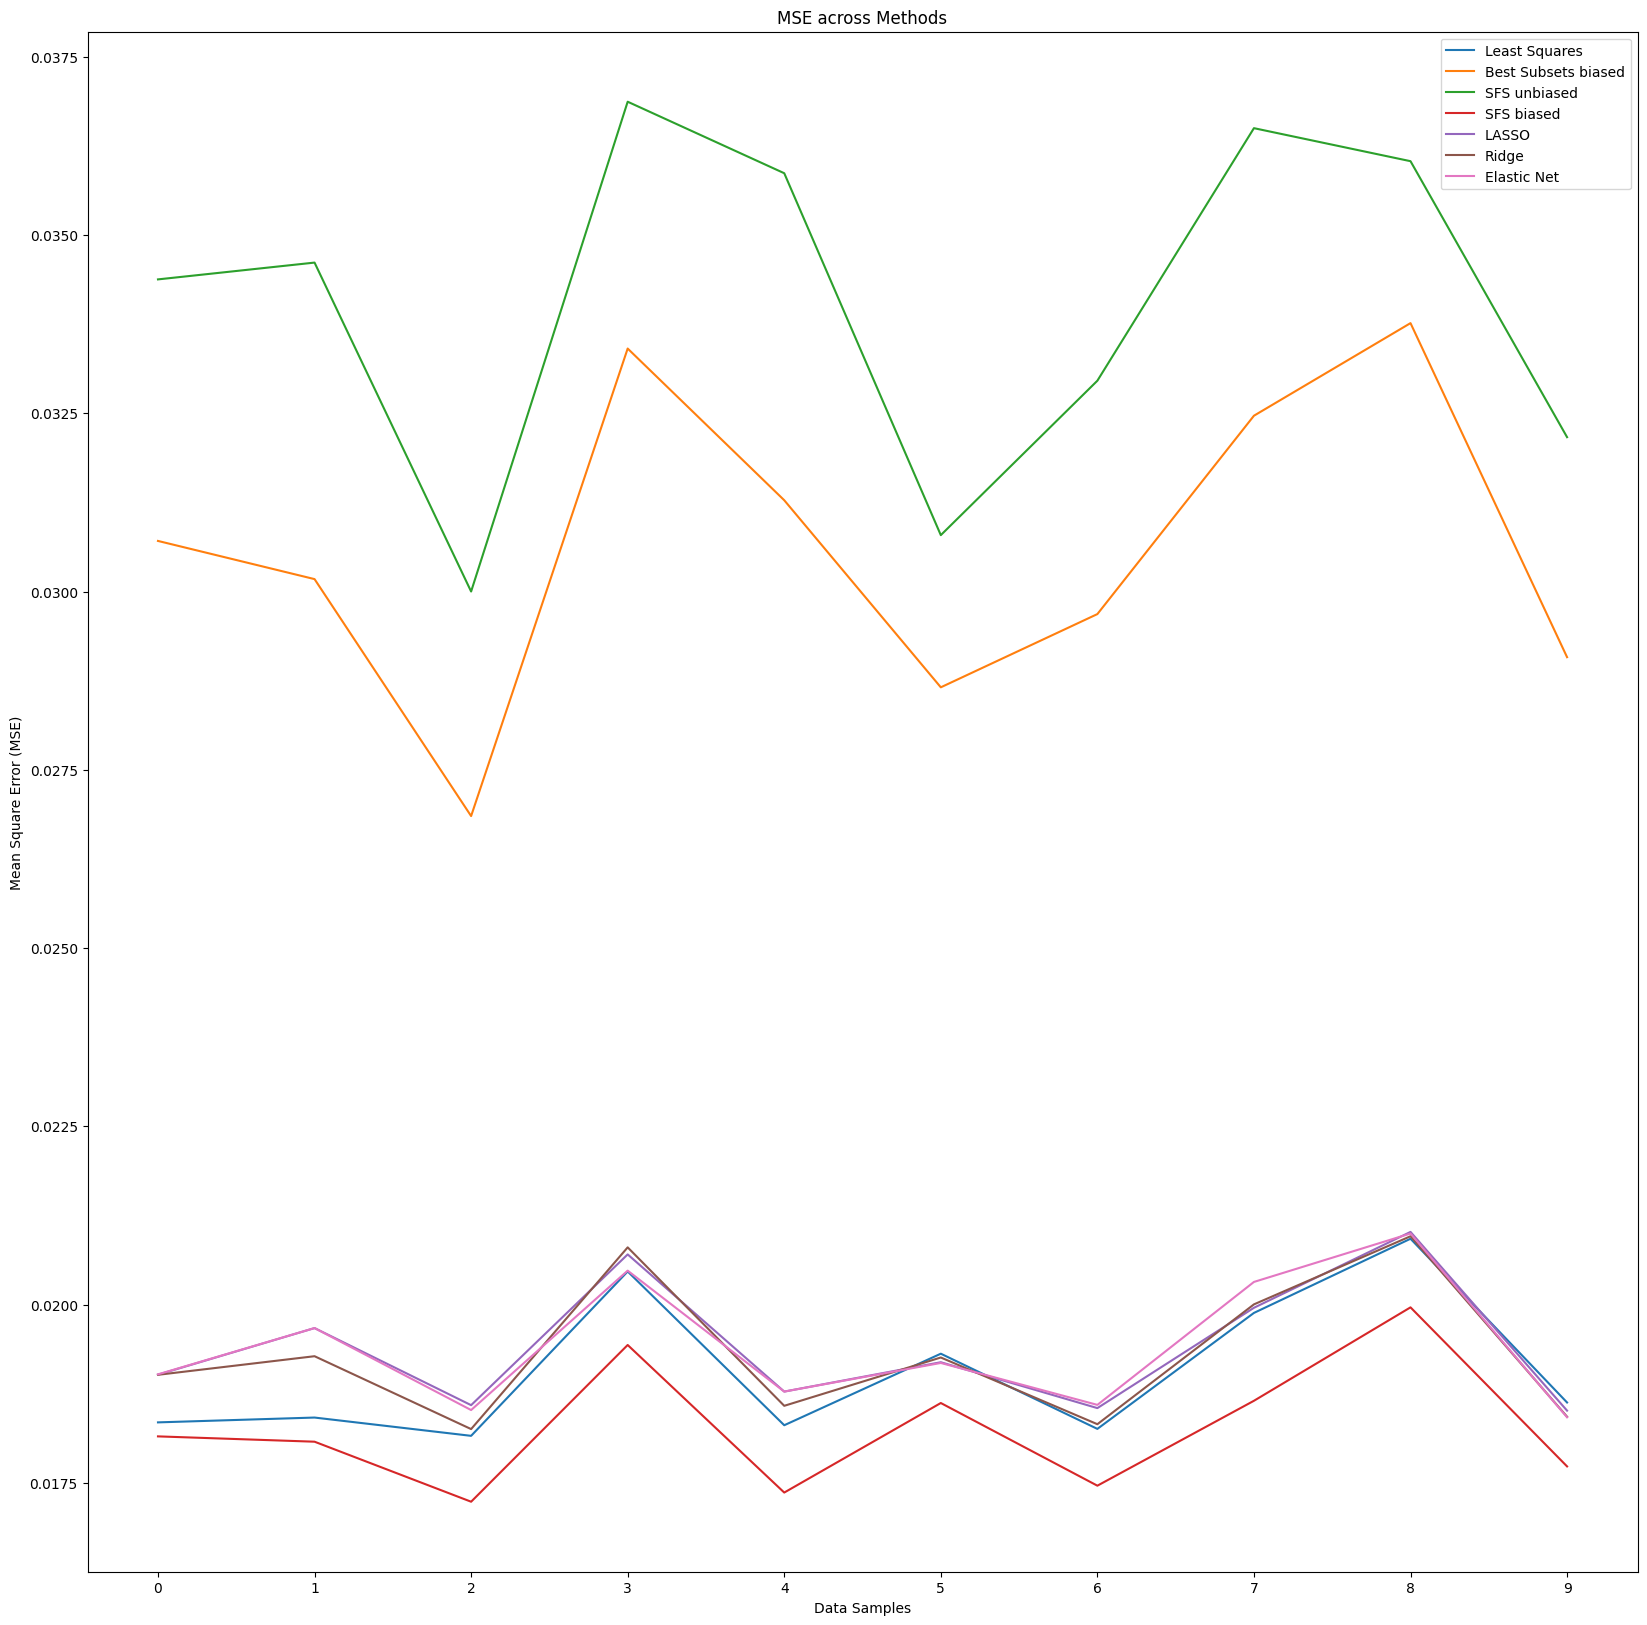

In [29]:
plt.figure(figsize=(20, 20))
for key, val in methods_mse.items():
  if len(list(methods_mse[key])) == 10:
    plt.plot(methods_mse[key].values(), label = key)
  else:
    plt.plot(methods_mse[key]['MSE'].values(), label = key)

plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Data Samples')
plt.title('MSE across Methods')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1));
plt.xticks(range(0, 10, 1));

## Average MSE Across all Data Samples

In [30]:
methods = list(methods_mse.keys())
average_mse = {method:0 for method in methods}

In [31]:
for method in methods:
  if len(list(methods_mse[method].keys())) == 10:
    mse = []
    for data_i in alldata:
      mse.append(methods_mse[method][data_i])
    mse_numpy = np.array(mse)
    avg_mse = mse_numpy.mean()
    average_mse[method] = avg_mse
  else:
    mse = []
    for data_i in alldata:
      mse.append(methods_mse[method]['MSE'][data_i])
    mse_numpy = np.array(mse)
    avg_mse = mse_numpy.mean()
    average_mse[method] = avg_mse

In [32]:
average_mse

{'Least Squares': 0.019070394416288796,
 'Best Subsets biased': 0.03060676004079548,
 'SFS unbiased': 0.03401640966984866,
 'SFS biased': 0.018269129788137266,
 'LASSO': 0.019399410635899193,
 'Ridge': 0.01929035444126297,
 'Elastic Net': 0.019398378977959152}

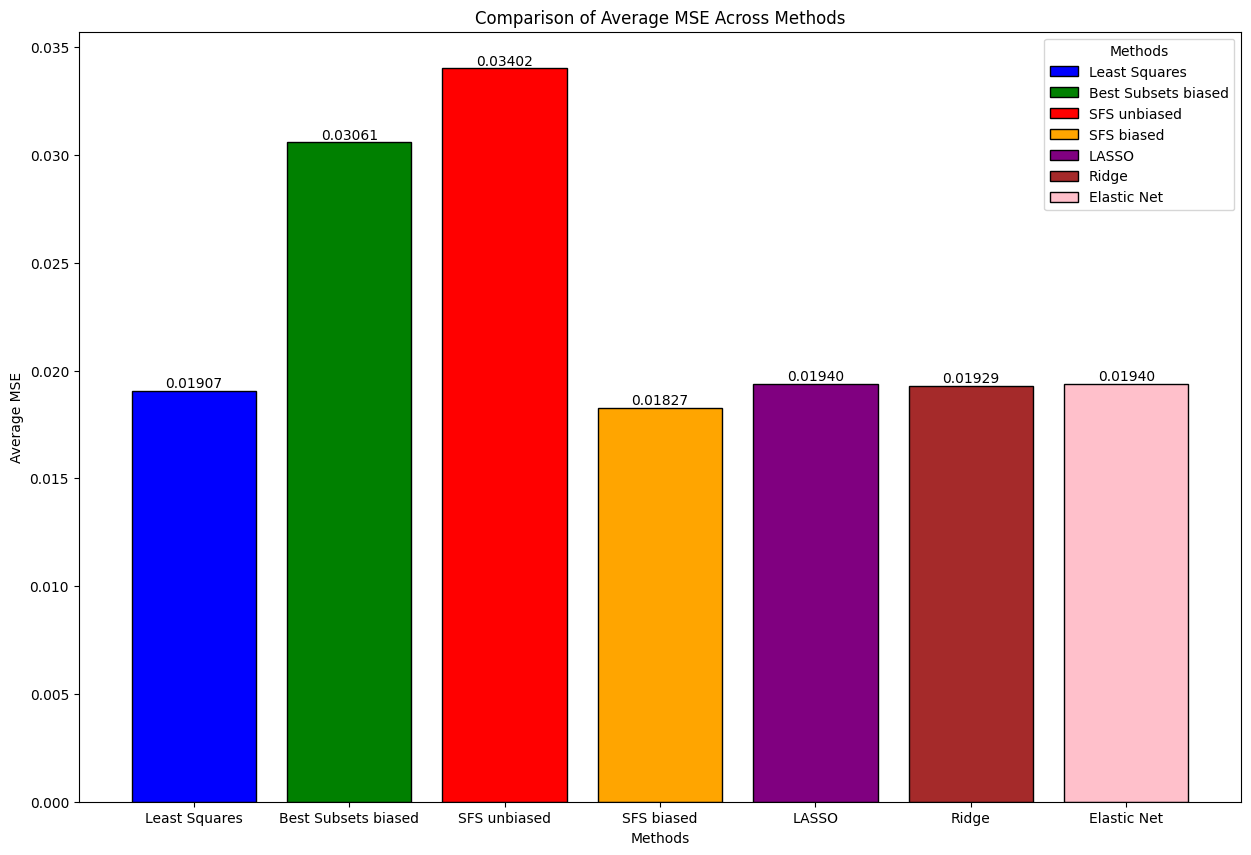

In [33]:
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink']
plt.figure(figsize=(15, 10))  # Set figure size
bars = plt.bar(methods, average_mse.values(), color=colors, edgecolor='black')

for bar in bars:
    yval = bar.get_height()  # Get the height (MSE value)
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.5f}', ha='center', va='bottom', fontsize=10)

for bar, method in zip(bars, methods):
    bar.set_label(method)  # Assign method name to each bar
plt.legend(title="Methods")

plt.xlabel('Methods')
plt.ylabel('Average MSE')
plt.title('Comparison of Average MSE Across Methods')

plt.show()
